In [1]:
%pip install ultralytics > /dev/null 2>&1
import yaml
from ultralytics import YOLO
import os
import cv2
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Define the paths to your training and validation data
train_img_path = '/kaggle/input/military-aircraft-detection-dataset-yolo-format/military/images/aircraft_train'
val_img_path = '/kaggle/input/military-aircraft-detection-dataset-yolo-format/military/images/aircraft_val'

# Load the class names from the provided file
with open('/kaggle/input/military-aircraft-detection-dataset-yolo-format/military/aircraft_names.yaml', 'r') as file:
    class_names = yaml.safe_load(file)['names']

# Create the data configuration dictionary
data_yaml = {
    'train': train_img_path,
    'val': val_img_path,
    'nc': len(class_names),  # Number of classes
    'names': class_names      # List of class names
}

with open('data.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=False)

!cat data.yaml

names:
  0: A10
  1: A400M
  2: AG600
  3: AV8B
  4: B1
  5: B2
  6: B52
  7: Be200
  8: C130
  9: C17
  10: C2
  11: C5
  12: E2
  13: E7
  14: EF2000
  15: F117
  16: F14
  17: F15
  18: F16
  19: F18
  20: F22
  21: F35
  22: F4
  23: J20
  24: JAS39
  25: MQ9
  26: Mig31
  27: Mirage2000
  28: P3
  29: RQ4
  30: Rafale
  31: SR71
  32: Su34
  33: Su57
  34: Tornado
  35: Tu160
  36: Tu95
  37: U2
  38: US2
  39: V22
  40: Vulcan
  41: XB70
  42: YF23
nc: 43
train: /kaggle/input/military-aircraft-detection-dataset-yolo-format/military/images/aircraft_train
val: /kaggle/input/military-aircraft-detection-dataset-yolo-format/military/images/aircraft_val


# EDA


--- Data Calculation Complete ---
Found and processed 9430 images.
Found a total of 15116 object instances.

--- Generating Plots ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

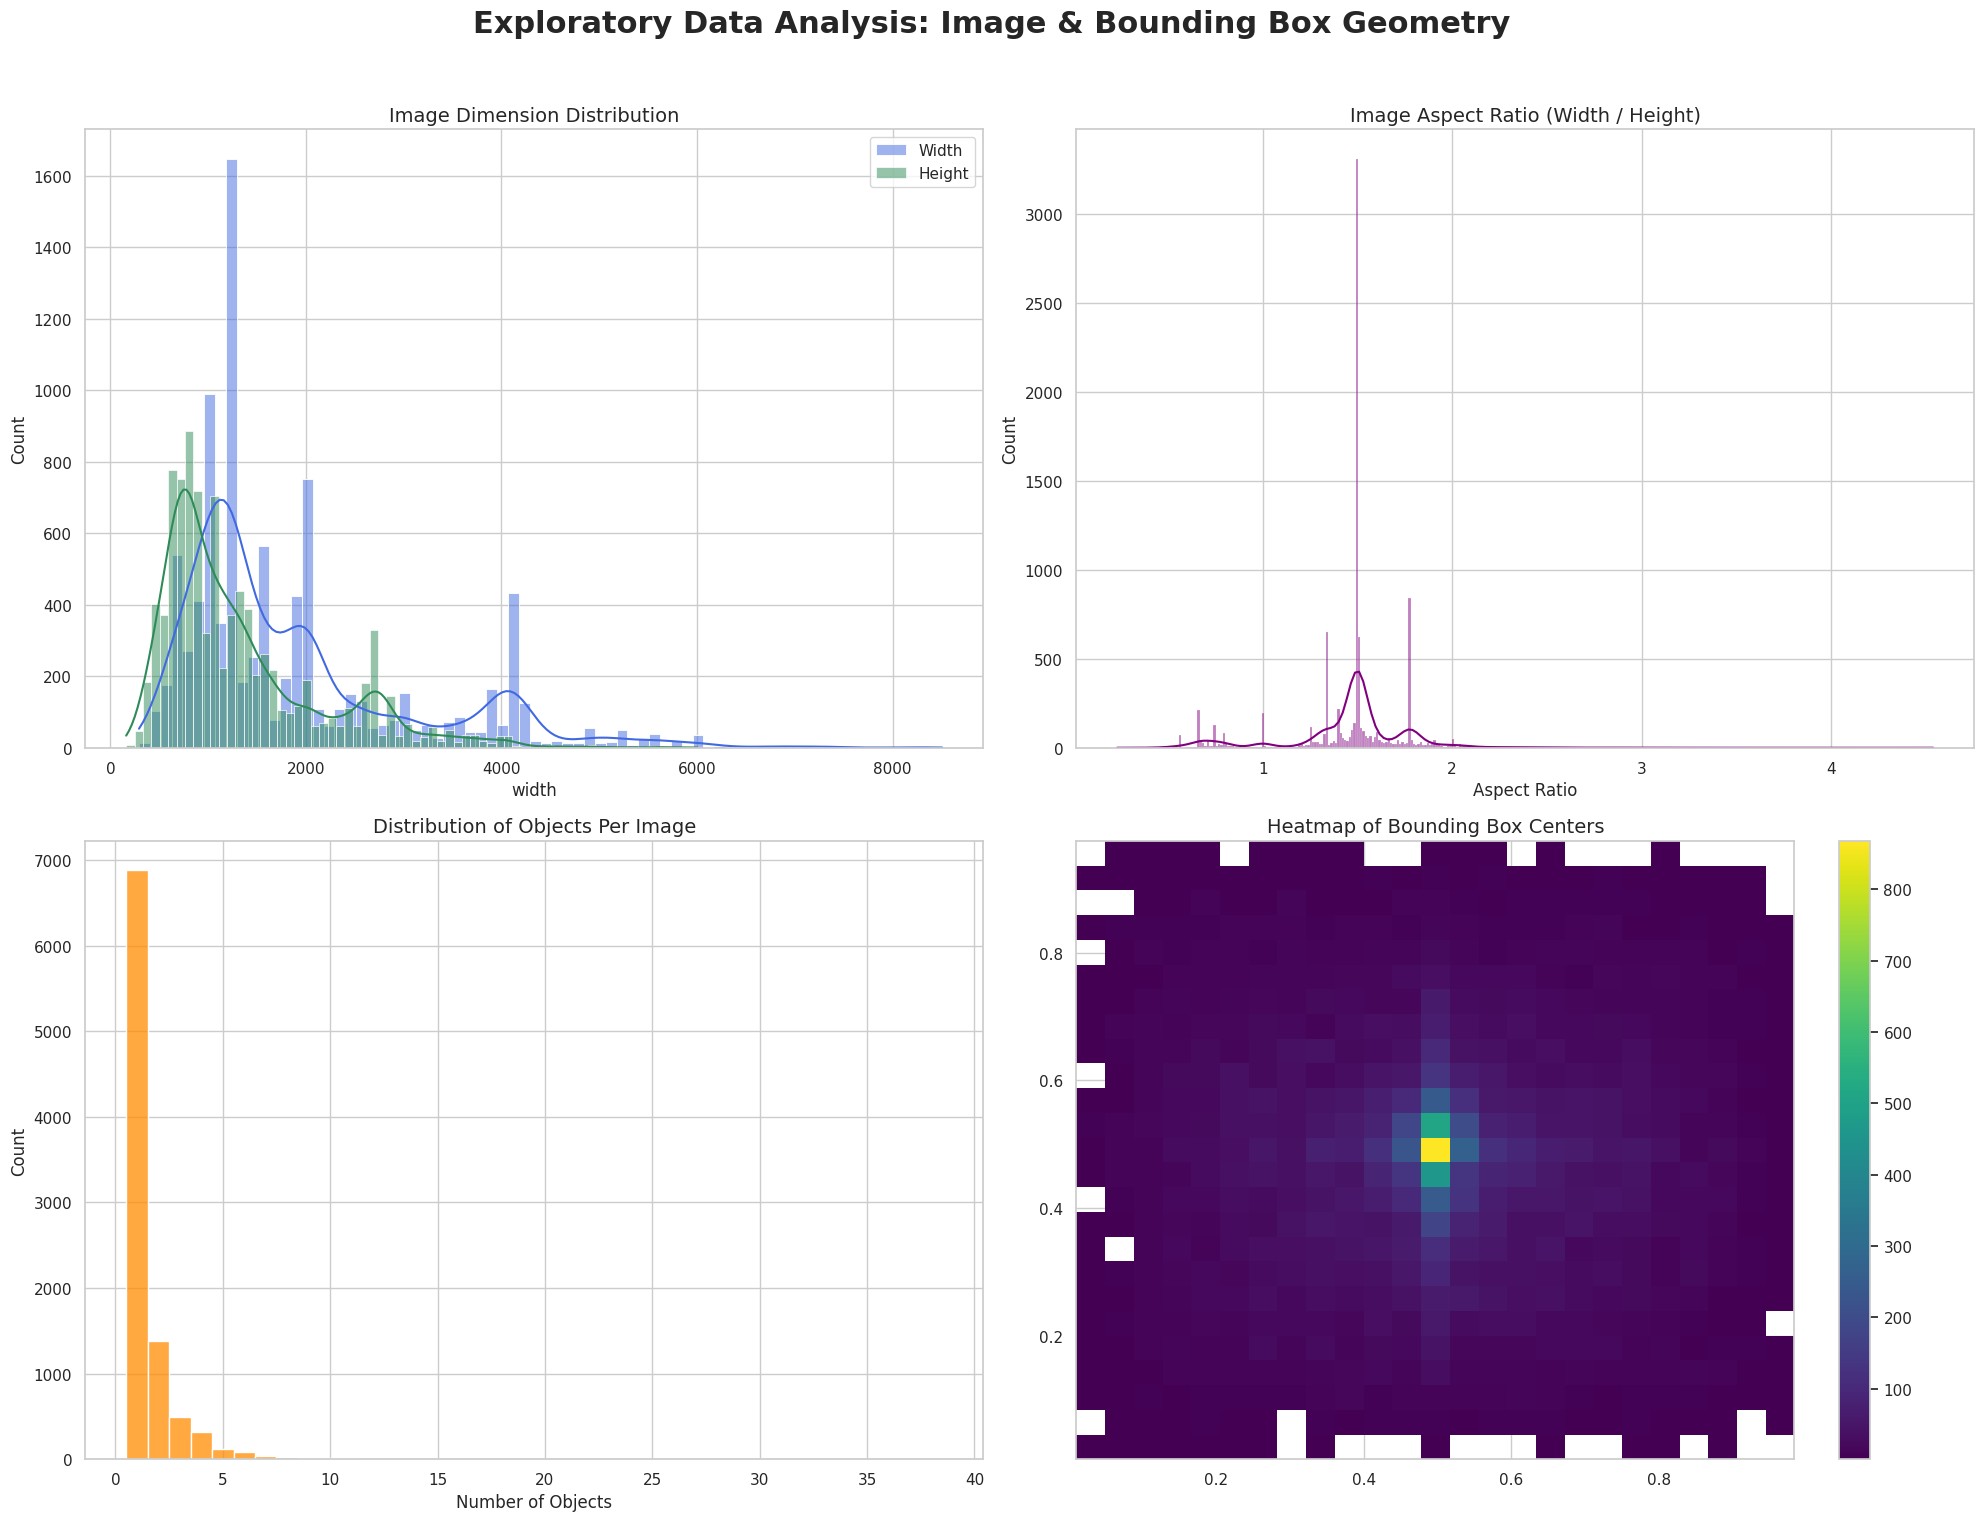

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


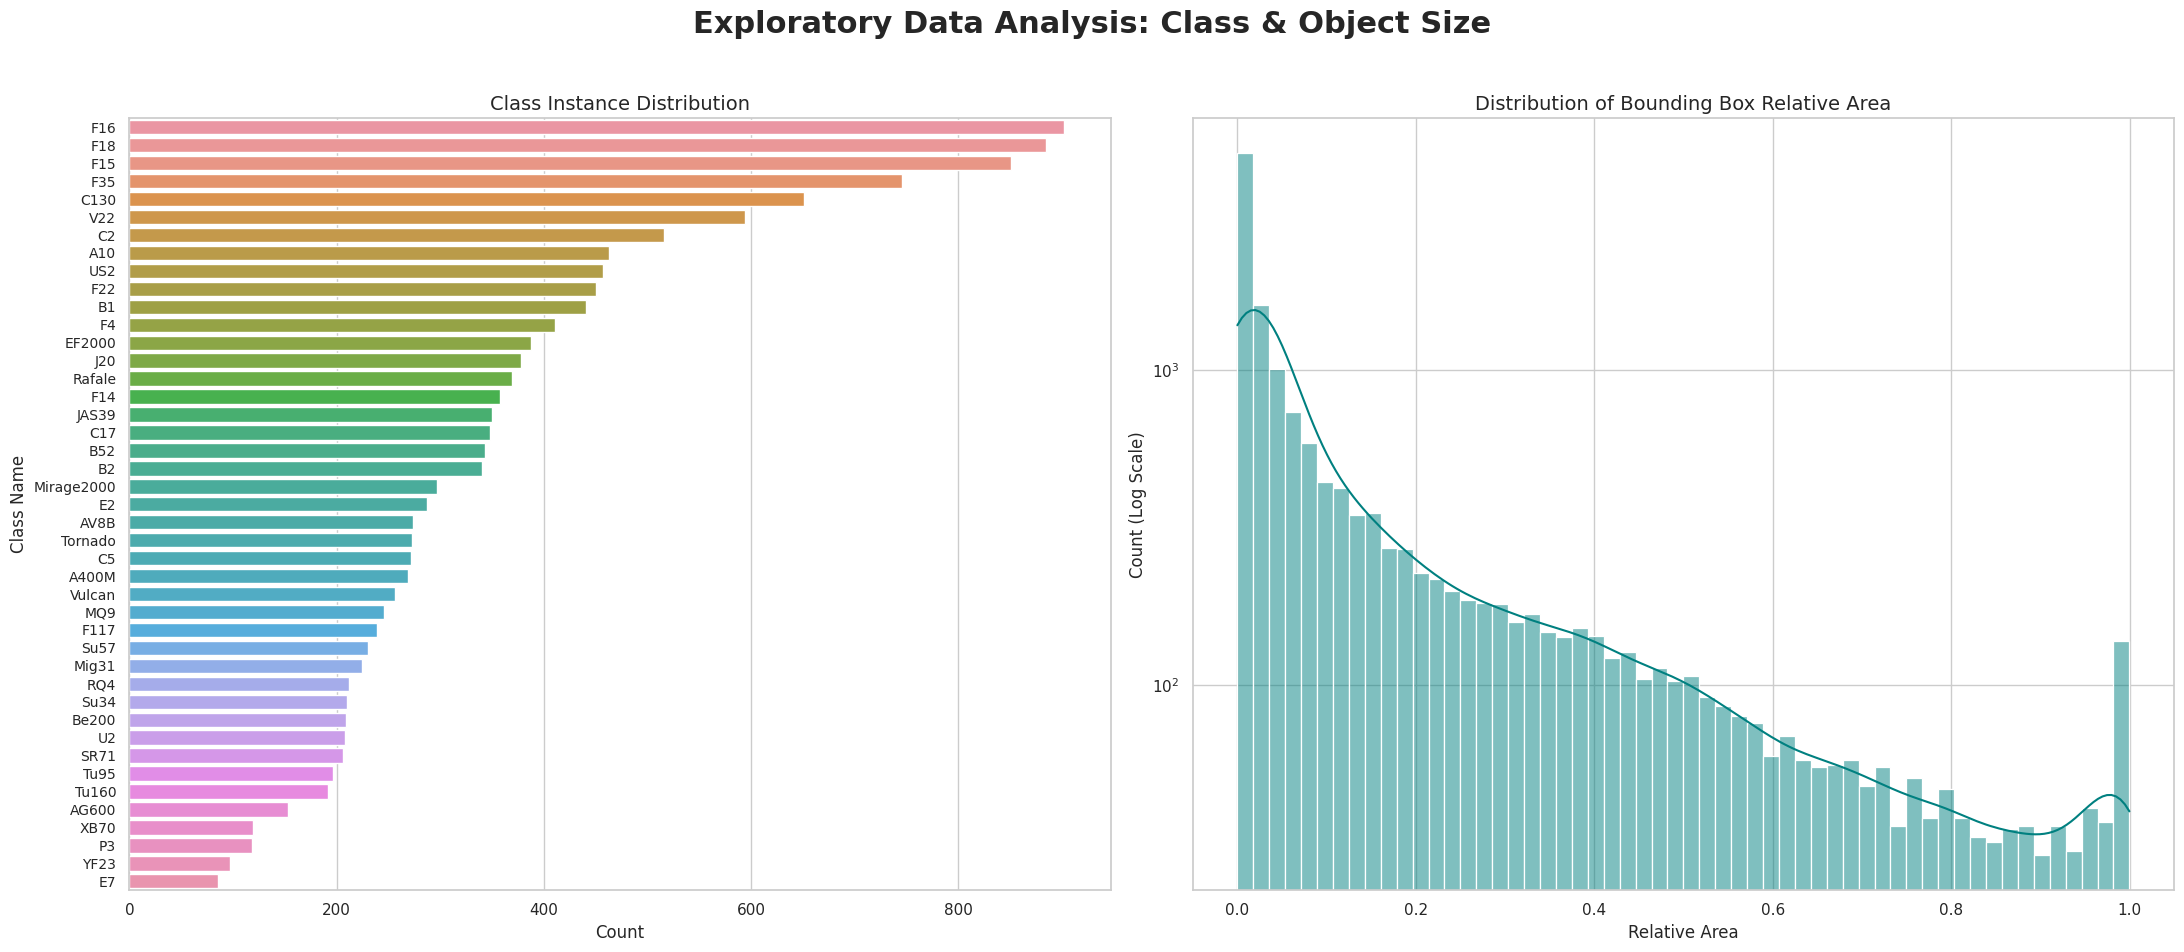


--- EDA complete. Charts saved to '/kaggle/working/eda_charts/' ---


In [3]:
# --- 1. Configuration ---
img_dir = '/kaggle/input/military-aircraft-detection-dataset-yolo-format/military/images/aircraft_train'
label_dir = '/kaggle/input/military-aircraft-detection-dataset-yolo-format/military/labels/aircraft_train'
yaml_path = '/kaggle/input/military-aircraft-detection-dataset-yolo-format/military/aircraft_names.yaml'
output_dir = '/kaggle/working/eda_charts/'

# --- 2. Data Calculation ---
# Initialize lists to store data
image_dims, aspect_ratios, objects_per_image, box_areas, box_centers = [], [], [], [], []
class_counts = {}

try:
    # Load class names to initialize class_counts
    with open(yaml_path, 'r') as file:
        class_names = yaml.safe_load(file)['names']
        class_counts = {i: 0 for i in range(len(class_names))}

    # Process each image and its corresponding label file
    for img_name in os.listdir(img_dir):
        if not img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue
        
        img_path = os.path.join(img_dir, img_name)
        img_data = cv2.imread(img_path)
        if img_data is None: continue # Skip corrupted or unreadable images

        h, w, _ = img_data.shape
        image_dims.append((w, h)); aspect_ratios.append(w / h)
        
        label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + '.txt')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                labels = f.readlines()
                objects_per_image.append(len(labels))
                for line in labels:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    if class_id in class_counts: class_counts[class_id] += 1
                    box_w, box_h = float(parts[3]), float(parts[4])
                    box_areas.append(box_w * box_h)
                    box_centers.append((float(parts[1]), float(parts[2])))
        else:
            objects_per_image.append(0)
    
    print("\n--- Data Calculation Complete ---")
    print(f"Found and processed {len(image_dims)} images.")
    print(f"Found a total of {sum(objects_per_image)} object instances.")

except Exception as e:
    print(f"An error occurred during data calculation: {e}")


# --- 3. Plotting ---
if len(image_dims) > 0:
    print("\n--- Generating Plots ---")
    os.makedirs(output_dir, exist_ok=True)
    sns.set_theme(style="whitegrid", palette="deep")

    # Plot 1: Geometry
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Exploratory Data Analysis: Image & Bounding Box Geometry', fontsize=22, weight='bold')
    
    df_sizes = pd.DataFrame(image_dims, columns=['width', 'height'])
    sns.histplot(df_sizes['width'], color='royalblue', label='Width', kde=True, ax=axes[0, 0])
    sns.histplot(df_sizes['height'], color='seagreen', label='Height', kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Image Dimension Distribution', fontsize=14); axes[0, 0].legend()
    
    sns.histplot(aspect_ratios, color='purple', kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Image Aspect Ratio (Width / Height)', fontsize=14); axes[0, 1].set_xlabel('Aspect Ratio')
    
    sns.histplot(objects_per_image, color='darkorange', discrete=True, ax=axes[1, 0])
    axes[1, 0].set_title('Distribution of Objects Per Image', fontsize=14); axes[1, 0].set_xlabel('Number of Objects')
    
    if box_centers:
        centers_df = pd.DataFrame(box_centers, columns=['x_center', 'y_center'])
        h = axes[1, 1].hist2d(centers_df['x_center'], centers_df['y_center'], bins=(25, 25), cmap='viridis', cmin=1)
        fig.colorbar(h[3], ax=axes[1, 1]); axes[1, 1].set_title('Heatmap of Bounding Box Centers', fontsize=14)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.savefig(os.path.join(output_dir, '1_geometry_overview.png'), dpi=120)
    plt.show()

    # Plot 2: Class & Size
    fig, axes = plt.subplots(1, 2, figsize=(22, 10))
    fig.suptitle('Exploratory Data Analysis: Class & Object Size', fontsize=22, weight='bold')
    
    class_names_list = list(class_names)
    df_classes = pd.DataFrame({'Class Name': [class_names[i] for i in class_counts.keys()], 'Count': list(class_counts.values())}).sort_values('Count', ascending=False)
    sns.barplot(x='Count', y='Class Name', data=df_classes, orient='h', ax=axes[0])
    axes[0].set_title('Class Instance Distribution', fontsize=14); axes[0].tick_params(axis='y', labelsize=10)
    
    sns.histplot(box_areas, color='teal', kde=True, ax=axes[1])
    axes[1].set_title('Distribution of Bounding Box Relative Area', fontsize=14); axes[1].set_xlabel('Relative Area'); axes[1].set_ylabel('Count (Log Scale)'); axes[1].set_yscale('log')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.savefig(os.path.join(output_dir, '2_class_and_size_distribution.png'), dpi=120)
    plt.show()
    
    print(f"\n--- EDA complete. Charts saved to '{output_dir}' ---")
else:
    print("\nCRITICAL WARNING: No data was loaded, so no plots were generated.")

# Hyperparameter Tuning

In [ ]:
persistent_model_dir = "/kaggle/working/persistent_models/"
os.makedirs(persistent_model_dir, exist_ok=True)

def save_checkpoint_callback(trainer):
    """Copies last.pt and best.pt to a persistent directory on save."""
    last_pt_path = trainer.last
    best_pt_path = trainer.best
    if os.path.exists(last_pt_path):
        shutil.copy(last_pt_path, os.path.join(persistent_model_dir, "last.pt"))
    if os.path.exists(best_pt_path):
        shutil.copy(best_pt_path, os.path.join(persistent_model_dir, "best.pt"))

model = YOLO('yolov8m.pt')
model.add_callback("on_model_save", save_checkpoint_callback)

Do not forget to set 'iteration' parameter

In [ ]:
model.tune(
    data='data.yaml',
    epochs=15,
    imgsz=800,
    project='aircraft_detection',
    name='yolov8m_tuning_run_test',
    batch=4,
    workers=4,
    patience=3
    # do not forget to set iteration parameter
    # make sure not to exceed 12 hour execution
)

You will use the best_hyperparameters.yaml file and best.pt to train the actual model.